In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torchvision.utils as utils
import numpy as np
import os
import matplotlib.pyplot as plt
from frechet_distance_cal import calculate_fretchet

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Generator(nn.Module):
    def __init__(self, text_input_dim, noise_dim):
        super(Generator, self).__init__()
        self.text_embedding = nn.Sequential(
            nn.Linear(text_input_dim, 256),
            nn.ReLU(),
        )
        self.model = nn.Sequential(
            nn.Linear(noise_dim + 256, 512*4*4),
            nn.BatchNorm1d(512*4*4),
            nn.ReLU(),
            nn.Unflatten(1, (512, 4, 4)),
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, text_input, noise):
        text_embedding = self.text_embedding(text_input)
        noise = noise.view(noise.size(0), -1)  # Reshape noise to match text embedding
        combined = torch.cat([noise, text_embedding], dim=1)
        return self.model(combined)

class Critic(nn.Module):
    def __init__(self, text_input_dim):
        super(Critic, self).__init__()
        self.text_embedding = nn.Sequential(
            nn.Linear(text_input_dim, 256),
            nn.ReLU(),
        )
        self.image_model = nn.Sequential(
            nn.Conv2d(3, 64, 5, 2, 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 5, 2, 2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 5, 2, 2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 5, 2, 2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )
        self.concat = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 4 * 4 + 256, 1),
        )

    def forward(self, image_input, text_input):
        text_embedding = self.text_embedding(text_input).view(-1, 256)
        image_features = self.image_model(image_input).view(image_input.size(0), -1)
        combined = torch.cat([image_features, text_embedding], dim=1)
        return self.concat(combined)

def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def compute_gradient_penalty(critic, real_samples, fake_samples, text_input):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = critic(interpolates, text_input)
    fake = torch.ones(d_interpolates.shape, device=device, requires_grad=False)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

def get_random_text_input(batch_size, text_input_dim, device):
    return torch.randn(batch_size, text_input_dim, device=device)

def plot_and_save_graph(gen_loss, dis_loss, fretchet_distances, out_path, epochs):
    import matplotlib.pyplot as plt
    import os
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 1, 1)
    plt.plot(gen_loss, label="Generator")
    plt.plot(dis_loss, label="Discriminator")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Generator and Discriminator Loss During Training")

    plt.subplot(2, 1, 2)
    plt.plot(range(epochs), fretchet_distances, label="FID")
    plt.xlabel("Epoch")
    plt.ylabel("FID")
    plt.legend()
    plt.title("FID vs Epochs")

    plt.subplots_adjust(hspace=0.5)  # Adjust the vertical spacing between subplots

In [3]:
# Set up training elements
CRITIC_ITERATIONS = 5
batch_size = 128
lr = 2e-4
epochs = 40
nz = 100
ngf = 64
text_input_dim = 119
ndf = 64
nc = 3
CRITIC_ITERATIONS = 5
lambda_gp = 10  # Gradient penalty lambda hyperparameter
G_losses = list()
D_losses = list()
img_list = list()
fretchet_distances = list()
out_path = 'WGaN_Out_40'

os.makedirs(out_path, exist_ok=True)


tf = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=tf)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

netG = Generator(119, 100).to(device)
netC = Critic(119).to(device)
netG.apply(weights_init)
netC.apply(weights_init)
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerC = optim.Adam(netC.parameters(), lr=0.0002, betas=(0.5, 0.999))
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    netG = nn.DataParallel(netG)
    netC = nn.DataParallel(netC)

optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerC = optim.Adam(netC.parameters(), lr=0.0002, betas=(0.5, 0.999))
fixed_noise = torch.randn(32, nz, 1, 1).to(device)
text_input_batch = get_random_text_input(32, text_input_dim, device)

real_label = 1.
fake_label = -1.  # Labels for the WGAN critic scores
iters = 0

Files already downloaded and verified
Using 2 GPUs!


In [4]:
netG.train(),netC.train()

(DataParallel(
   (module): Generator(
     (text_embedding): Sequential(
       (0): Linear(in_features=119, out_features=256, bias=True)
       (1): ReLU()
     )
     (model): Sequential(
       (0): Linear(in_features=356, out_features=8192, bias=True)
       (1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ReLU()
       (3): Unflatten(dim=1, unflattened_size=(512, 4, 4))
       (4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
       (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (6): ReLU()
       (7): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
       (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (9): ReLU()
       (10): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
       (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

Starting Training Loop...


/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.10-dtqfczcbv33ugxmsznhll4vjexdcxjfn/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.10-dtqfczcbv33ugxmsznhll4vjexdcxjfn/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch [0/40] Batch 390/391 Loss Discriminator: -1409.269, Loss Generator: 3276.792 FID: 389.102

Epoch [5/40] Batch 390/391 Loss Discriminator: -397.448, Loss Generator: 14810.719 FID: 318.058

Epoch [10/40] Batch 390/391 Loss Discriminator: -229.393, Loss Generator: -14834.546 FID: 290.712

Epoch [15/40] Batch 390/391 Loss Discriminator: -1630.535, Loss Generator: 8307.180 FID: 291.071

Epoch [20/40] Batch 390/391 Loss Discriminator: -259.105, Loss Generator: -27146.844 FID: 316.514

Epoch [25/40] Batch 390/391 Loss Discriminator: -1112.977, Loss Generator: 24746.795 FID: 279.801

Epoch [30/40] Batch 390/391 Loss Discriminator: -7176.307, Loss Generator: 30070.688 FID: 324.400

Epoch [35/40] Batch 390/391 Loss Discriminator: -840.331, Loss Generator: -8072.259 FID: 279.111
Training has finished.


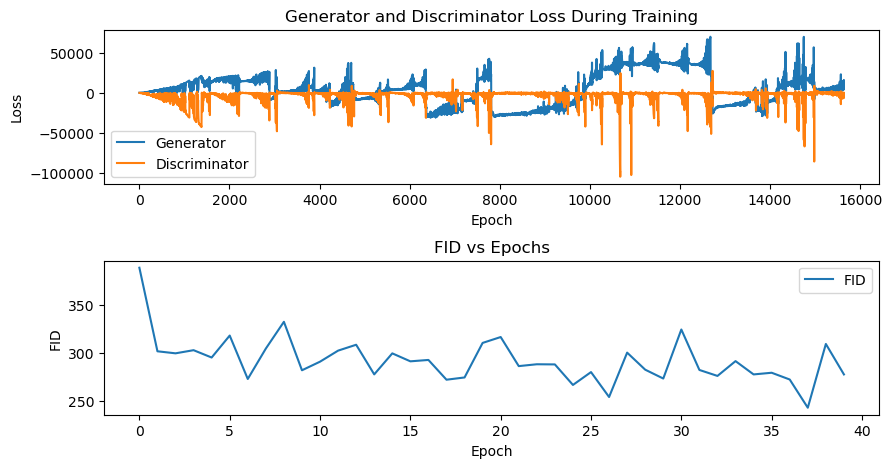

In [5]:
print("Starting Training Loop...")
for epoch in range(epochs):
    for i, (images, _) in enumerate(dataloader):
        real_images = images.to(device)
        b_size = real_images.size(0)
        real_text_input = get_random_text_input(b_size, 119, device)
        fake_text_input = get_random_text_input(b_size, 119, device)

        # Critic updates
        for _ in range(CRITIC_ITERATIONS):
            netC.zero_grad()
            noise = torch.randn(b_size, 100, device=device)  # Generate fresh noise
            fake_images = netG(fake_text_input, noise).detach()

            real_preds = netC(real_images, real_text_input)
            fake_preds = netC(fake_images, fake_text_input)
            d_loss_real = -torch.mean(real_preds)
            d_loss_fake = torch.mean(fake_preds)

            gradient_penalty = compute_gradient_penalty(netC, real_images, fake_images, real_text_input)
            d_loss = d_loss_real + d_loss_fake + lambda_gp * gradient_penalty
            d_loss.backward()
            optimizerC.step()

        # Generator update
        netG.zero_grad()
        generated_images = netG(fake_text_input, noise)
        g_loss = -torch.mean(netC(generated_images, fake_text_input))
        g_loss.backward()
        optimizerG.step()
        G_losses.append(g_loss.detach().cpu())
        D_losses.append(d_loss.detach().cpu())
        if iters % 300 == 0 or ((epoch == epochs-1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake_images = netG(text_input_batch, fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake_images, padding=2, normalize=True))

        iters += 1

    # Calculate FID at the end of each epoch
    with torch.no_grad():
        fretchet_dist = calculate_fretchet(real_images.cpu(), generated_images.cpu())
    fretchet_distances.append(fretchet_dist)

    # Print epoch summary
    if epoch % 5 == 0:
        print(f'\nEpoch [{epoch}/{epochs}] Batch {i}/{len(dataloader)} '
              f'Loss Discriminator: {d_loss.item():.3f}, Loss Generator: {g_loss.item():.3f} FID: {fretchet_dist:.3f}')
        with torch.no_grad():
            images = netG(text_input_batch, fixed_noise).detach()
    image_fake_path = out_path+'/fake_samples_epoch_%03d.png' % epoch
    image_real_path = out_path+'/real_samples_epoch_%03d.png' % epoch
    utils.save_image(generated_images.detach(),image_fake_path, normalize = True)
    utils.save_image(real_images.detach(),image_real_path, normalize = True)
with open(os.path.join(out_path, 'gen_error.txt'), 'w') as f:
    for line in G_losses:
        f.write(f"{line}\n")

with open(os.path.join(out_path, 'dis_error.txt'), 'w') as f:
    for line in D_losses:
        f.write(f"{line}\n")

with open(os.path.join(out_path, 'fretchet_distances.txt'), 'w') as f:
    for line in fretchet_distances:
        f.write(f"{line}\n")
        
plot_and_save_graph(G_losses, D_losses, fretchet_distances, out_path, epochs)
print('Training has finished.')

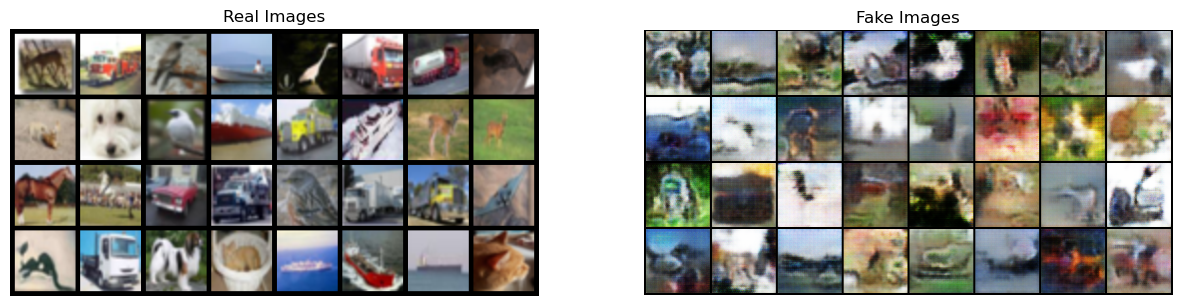

In [7]:
import numpy as np
real_batch = next(iter(dataloader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:32], padding=5, normalize=True).cpu(),(1,2,0)))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.savefig('WGaN_Out_40/WGAN30_BEST_FAKE_32.png',
            format='png',
            bbox_inches='tight')
plt.show()